**TFM - Latent space comparison between different generative models (VAE, GAN, StyleGAN...)**

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from IPython import display

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.2.2+cu121
CUDA version: 12.1
CUDA available: True
Number of GPUs: 1


Loading dataset

In [9]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


**VAE architecture**

In [10]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).cuda()   
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

Initialize VAE

In [11]:
model = VAE().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Loss function

In [12]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

Train model

In [13]:
def train(model, optimizer, epochs, x_dim=784):
    model.train()
    history = {'loss': []}  # Track loss
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).cuda()
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        avg_loss = overall_loss/(batch_idx*batch_size)
        history['loss'].append(avg_loss)
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", avg_loss)
    return history

# Run and store training history
vae_history = train(model, optimizer, epochs=50)

	Epoch 1 	Average Loss:  175.9802632969011
	Epoch 2 	Average Loss:  157.12858439195534
	Epoch 3 	Average Loss:  152.4501569836446
	Epoch 4 	Average Loss:  149.42556880282243
	Epoch 5 	Average Loss:  147.36386651906824
	Epoch 6 	Average Loss:  145.71748793562188
	Epoch 7 	Average Loss:  144.45062682595994
	Epoch 8 	Average Loss:  143.26194697868843
	Epoch 9 	Average Loss:  142.53674046588063
	Epoch 10 	Average Loss:  141.9684845673779
	Epoch 11 	Average Loss:  140.97232759351525
	Epoch 12 	Average Loss:  140.5108518592185
	Epoch 13 	Average Loss:  139.98253115544136
	Epoch 14 	Average Loss:  139.5622177750678
	Epoch 15 	Average Loss:  139.18866145724644
	Epoch 16 	Average Loss:  138.56395943108305
	Epoch 17 	Average Loss:  138.30245149793927
	Epoch 18 	Average Loss:  137.82940568264817
	Epoch 19 	Average Loss:  137.61032436873955
	Epoch 20 	Average Loss:  137.27074714367697
	Epoch 21 	Average Loss:  137.01557848693133
	Epoch 22 	Average Loss:  136.69632877712854
	Epoch 23 	Average Loss:

VAE loss curves

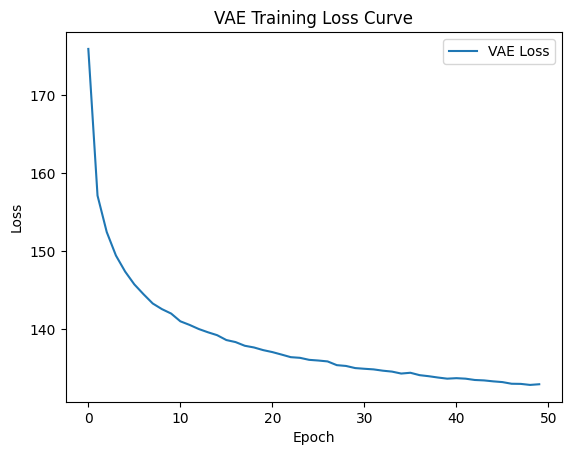

In [14]:

def plot_loss(history, title):
    plt.plot(history['loss'], label='VAE Loss')
    plt.title(f'{title} Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(vae_history, 'VAE')

Image generation

In [15]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

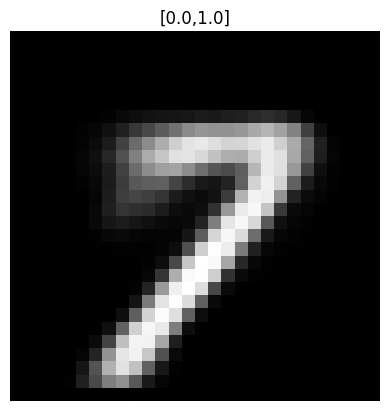

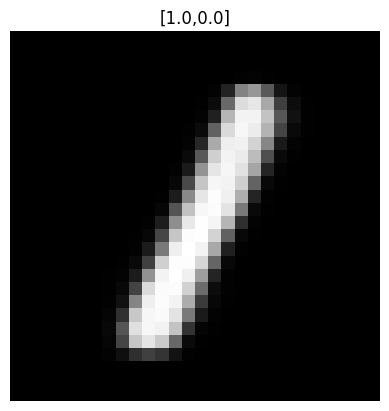

(None, None)

In [16]:
#img1: mean0, var1 / img2: mean1, var0
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

Latent space visualization

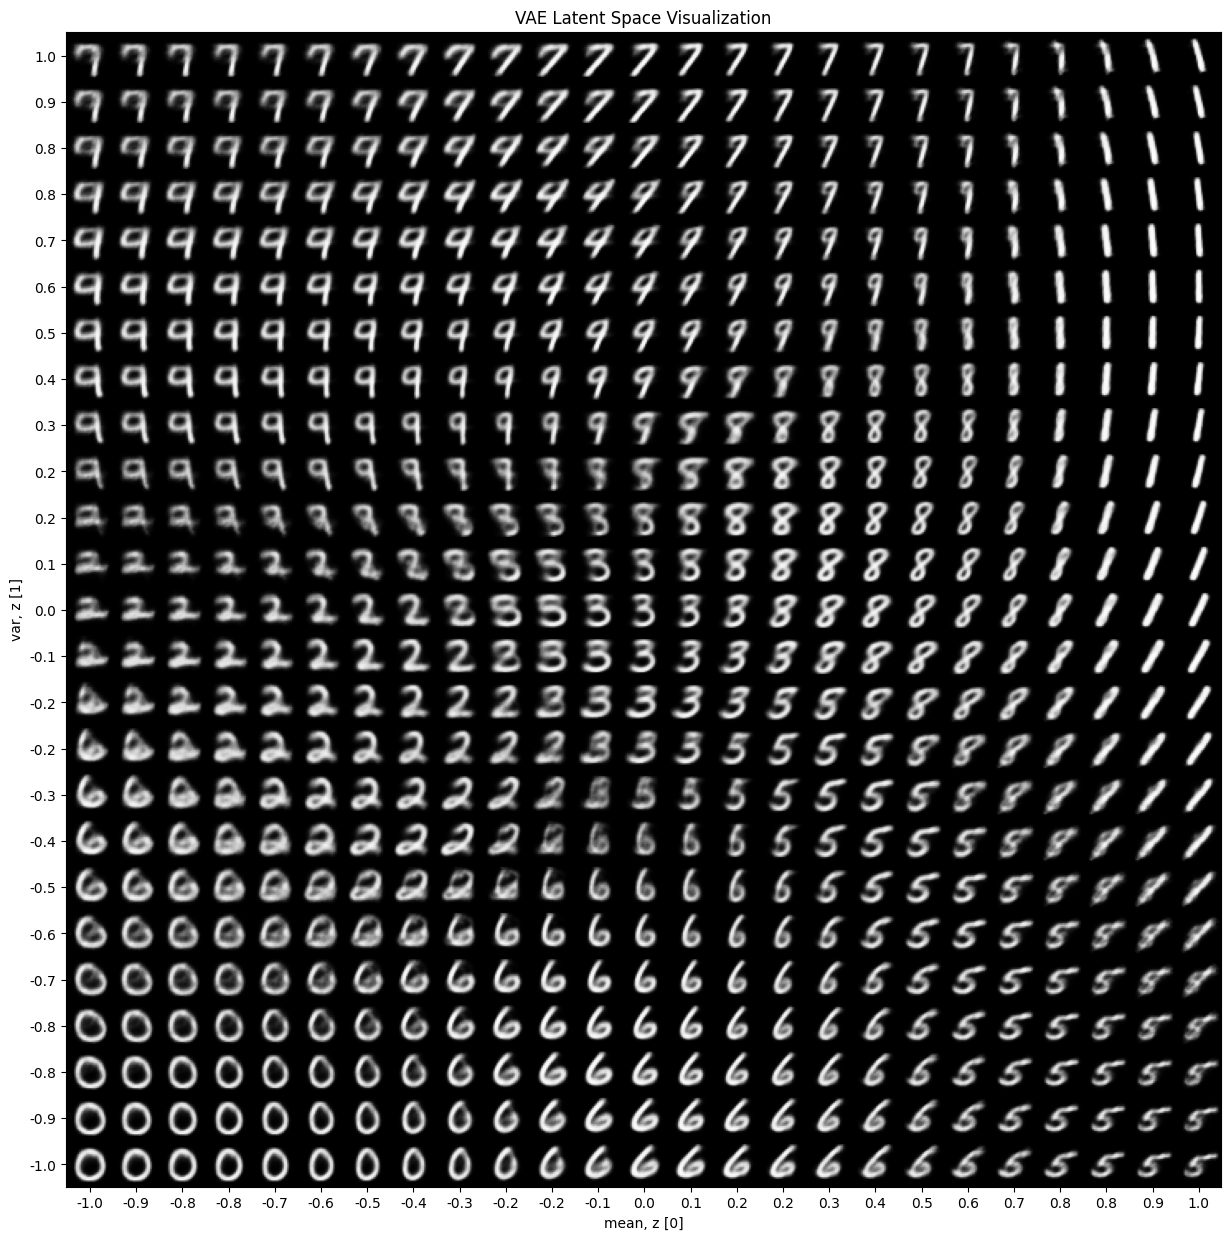

In [17]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)